In [1]:
import os
import numpy as np
import torch
import pandas as pd
import datetime
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import itertools as iter
from random import shuffle

DATA_PATH = "E:/ML/MonetGAN"
print(DATA_PATH)


E:/ML/MonetGAN


In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Dataset

In [3]:
allFiles=[]
for root, dirs, files in os.walk(os.path.join(DATA_PATH, "processed")):
    for f in files:
        allFiles.append(os.path.join(root, f))

In [4]:
IMAGE_SIZE = [128,128]

images=[]
for i,file in enumerate(tqdm(allFiles)):
    with Image.open(file) as im:
        # (width, height) = (im.width // 4, im.height // 4)
        im_resized = im.resize((IMAGE_SIZE[0], IMAGE_SIZE[1]))
        images.append(np.array(im_resized))

  0%|          | 0/1884 [00:00<?, ?it/s]

100%|██████████| 1884/1884 [00:23<00:00, 79.05it/s] 


In [5]:
T=1000
tValues = np.arange(0,T)


#linear schedule
# beta = np.linspace(1e-4, 0.015, T)
# alpha = 1-beta
# alphaBar = [np.prod(alpha[0:i+1]) for i,el in enumerate(alpha)]
# alphaBar = np.array(alphaBar)


def sigmoid(z):
    return 1/(1 + np.exp(-z))

#Cosine schedule
# def f(t):
#     return np.cos((t/T + 0.008)/(1 + 0.008) * np.pi/2)**2

# alphaBar = f(tValues)
# alpha = (alphaBar[1:])/(alphaBar[0:-1])
# alpha = np.insert(alpha, 0, alphaBar[0])
# beta = 1 - alpha



# Simple linear
alphaBar = np.clip(1-tValues/T, 0.0001, 0.9999)
alpha = (alphaBar[1:])/(alphaBar[0:-1])
alpha = np.insert(alpha, 0, alphaBar[0])
beta = 1 - alpha



def forwardStep(x0Image,t, inputScaling=1.0):
    noise = np.random.normal(0, 1, x0Image.shape)
    noisy = np.sqrt(alphaBar[t])*x0Image*inputScaling + np.sqrt(1-alphaBar[t])*noise
    return noise, noisy

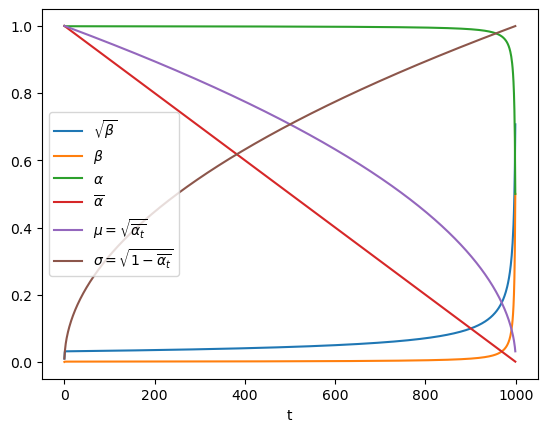

In [6]:
# _ = plt.plot(beta, label="beta")
_ = plt.plot(np.sqrt(beta), label=r"$\sqrt{\beta}$")
_ = plt.plot(beta, label=r"$\beta$")
_ = plt.plot(alpha, label=r"$\alpha$")
_ = plt.plot(alphaBar, label=r"$\overline{\alpha}$")
_ = plt.plot(np.sqrt(alphaBar), label=r"$\mu = \sqrt{ \overline{\alpha_t} }$")
_ = plt.plot(np.sqrt(1-np.array(alphaBar)[np.arange(0,T)]), label=r"$\sigma = \sqrt{ 1-\overline{\alpha_t} }$")
# _ = plt.plot( (1-alpha)/(np.sqrt(1-np.array(alphaBar)*np.sqrt(alpha))) , label=r"$\frac{1-\alpha}{\sqrt{1-\overline{\alpha}}*\sqrt{\alpha}}}$")
_ = plt.legend()
_ = plt.xlabel("t")

In [7]:



# Make a combination of all images and all possible t values and shuffle them
# trainComb = [el for el in iter.product(np.arange(0,len(images)), tValues)]
# shuffle(trainComb)
# dataSize = len(trainComb)

#This generator provides all the timesteps for all images --> A huge dataset with comparably low variation
# def generator():
#     for fileIdx,tValue in trainComb:
#         # image = tf.io.read_file(file)
#         # image = tf.io.decode_jpeg(image, channels=3)
#         image = tf.convert_to_tensor(images[fileIdx])
#         image = tf.image.random_brightness(image, 0.1)
#         image = tf.image.random_contrast(image, 0.95, 1.05)
#         image = (tf.cast(image, tf.float32) / 127.5) - 1
#         x0 = image.numpy()
#         noise, noisy = forwardStep(x0, tValue)
#         yield noisy, noise, [tValue], x0

# Generator that outputs random time steps per image
repeats=5
def generator():
    for im in images:
        # image = tf.io.read_file(file)
        # image = tf.io.decode_jpeg(image, channels=3)
        # image = tf.convert_to_tensor(im)
        # image = tf.image.random_brightness(image, 0.1)
        # image = tf.image.random_contrast(image, 0.95, 1.05)
        # image = (tf.cast(image, tf.float32) / 127.5) - 1
        x0 = (im/127.5)-1
        tValues = np.random.choice(T,repeats, replace=False)
        for tValue in tValues:
            noise, noisy = forwardStep(x0, tValue, 0.7)
            yield noisy.astype(np.float32), noise.astype(np.float32), [tValue], x0

# Generator that outputs nSamplesPerTStep for ever t in (0,T)
# samplesPerTStep=10
# trainComb = []
# for t in range(T):
#     randomFiles = np.random.choice(np.arange(0,len(images)), samplesPerTStep, replace=False)
#     for randomFile in randomFiles:
#         trainComb.append(( randomFile, t))
# shuffle(trainComb)
# dataSize = len(trainComb)
# print(dataSize)

# def generator():
#     for fileIdx,tValue in trainComb:
#         im = images[fileIdx]
#         x0 = (im/127.5)-1
#         noise, noisy = forwardStep(x0, tValue)
#         yield noisy, noise, [tValue], x0

In [8]:
def postprocessImage(im):
    return np.clip(im/2+0.5,0,1)

In [9]:
g = generator()
test = next(g)
print(test[2])
print(test[0].shape)
print(test[1].shape)

[202]
(128, 128, 3)
(128, 128, 3)


In [10]:
test = next(g)
print(np.max(test[0]))
print(test[2])

1.7302316
[91]


Text(0.5, 1.0, 'Noise')

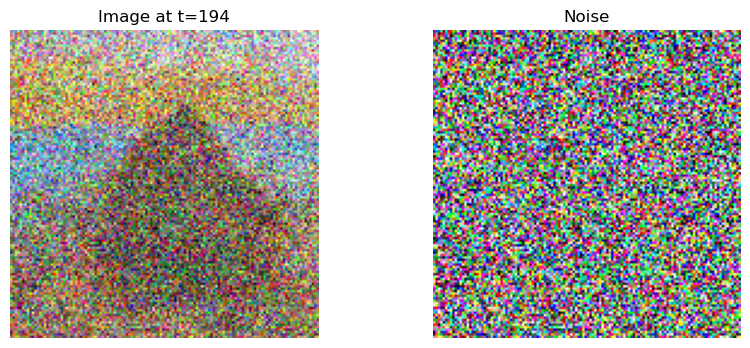

In [11]:
test = next(g)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(postprocessImage(test[0]))
plt.axis('off')
plt.title("Image at t="+str(test[2][0]))
plt.subplot(1,2,2)
plt.imshow(postprocessImage(test[1]))
plt.axis('off')
plt.title("Noise")

In [12]:
BATCH_SIZE = 64

class IterDataset(torch.utils.data.IterableDataset):
    def __init__(self, generator, length):
        self.generator = generator
        self.len = length

    def __iter__(self):
        return self.generator()
    
    def __len__(self):
        return self.len
    
dataset = IterDataset(generator, len(images)*repeats)

trainLoader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

## Testing of the forward and backward process

Test the denoising steps all at one (what the neural network should predict gradually)

(-0.5, 127.5, 127.5, -0.5)

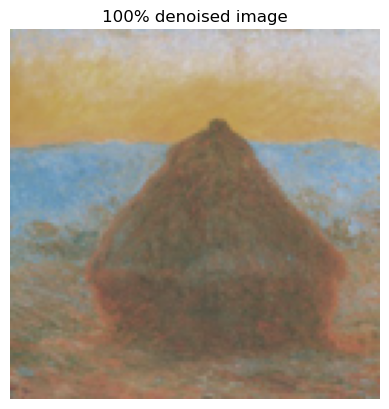

In [13]:
testDenoised = (test[0] - np.sqrt(1-alphaBar[test[2][0]])*test[1])/np.sqrt(alphaBar[test[2][0]])
plt.imshow((testDenoised+1)/2)
plt.title("100% denoised image")
plt.axis('off')

Forward pass

In [14]:
noisyImages=[]
noises=[]
x0=images[0]/127.5-1
for tStep in range(T):
    noise, noisy = forwardStep(x0, tStep)
    noisyImages.append(noisy)
    noises.append(noise)

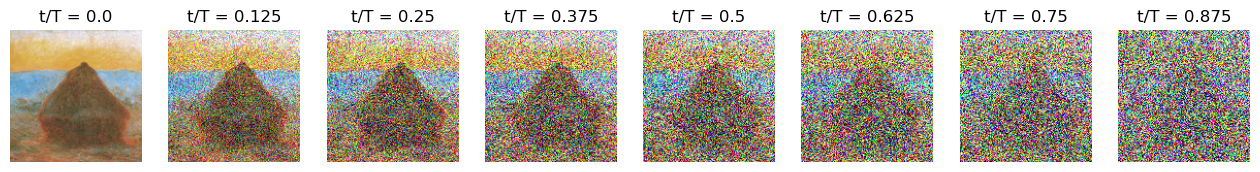

In [15]:
plt.figure(figsize=(16,5))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(postprocessImage(noisyImages[int(i*T/8)]))
    plt.axis("off")
    plt.title("t/T = "+str(i/8))

Backward pass

In [16]:
samples = [noisyImages[-1]]
predNoises = [noises[-1]]

def backwardStepTesting(xt, t, predNoise=None, x0Pred=None):

    if x0Pred is None:
        x0Pred=(xt - np.sqrt(1-alphaBar[t])*predNoise)/np.sqrt(alphaBar[t])

    if t>1:
        randNoise= np.random.normal(0,1,xt.shape)
    else:
        randNoise= np.zeros(xt.shape)
   
    # estimate mean
    meanPred= x0Pred * (np.sqrt(alphaBar[t])*beta[t])/((1-alphaBar[t])*np.sqrt(alpha[t])) + xt*(alpha[t]-alphaBar[t])/((1-alphaBar[t])*np.sqrt(alpha[t]))
    # compute variance
    betaPred = np.sqrt(beta[t])
    sample = meanPred + betaPred*randNoise
    noise=(sample-x0Pred*np.sqrt(alphaBar[t-1]))/np.sqrt(1-alphaBar[t-1])

    return sample, noise


variance = np.append(np.array([0]), beta[1:]*(1-alphaBar[0:T-1])/(1-alphaBar[1:T]))
def backwardStep(xt, t, predNoise):
    if t>1:
        randNoise = torch.randn(xt.shape)
    else:
        randNoise= torch.zeros(xt.shape)

    # sigPred = np.sqrt(beta)
    # xtPrev = (1/np.sqrt(alpha[t])) * (xt - (1-alpha[t])/(np.sqrt(1-alphaBar[t])) * predNoise) + sigPred[t]*randNoise

    x0Pred = (1/np.sqrt(alphaBar[t])) * (xt - np.sqrt(1-alphaBar[t]) * predNoise)
    x0Pred = np.clip(x0Pred, -1.0, 1.0)
    meanPred = beta[t] * (np.sqrt(alphaBar[t-1]))/(1-alphaBar[t]) * x0Pred + (1-alphaBar[t-1])*(np.sqrt(alpha[t]))/(1-alphaBar[t]) * xt
    xtPrev = meanPred + np.sqrt(variance[t]) * randNoise

    return xtPrev

def backwardStepDDIM(xt, t, predNoise, sig=0):
    if sig>0:
        if t>1:
            randNoise = torch.randn(xt.shape)
        else:
            randNoise= torch.zeros(xt.shape)
    else:
        randNoise=0

    if t==1:
        xtPrev = xt 
    else:
        predX0 = (xt - np.sqrt(1-alphaBar[t])*predNoise)/np.sqrt(alphaBar[t])
        xtPrev = np.sqrt(alphaBar[t-1]) * predX0 + np.sqrt(1-alphaBar[t-1]-sig**2)*predNoise + sig*randNoise

    return xtPrev


for t in np.arange(0,T)[::-1]:
    predNoise = predNoises[-1]
    xt = samples[-1]

    sample, noise = backwardStepTesting(xt, t, predNoise=predNoise)
    # sample, noise = backwardStep(xt, t, x0Pred=noisyImages[0])

    samples.append(sample)
    predNoises.append(noise)

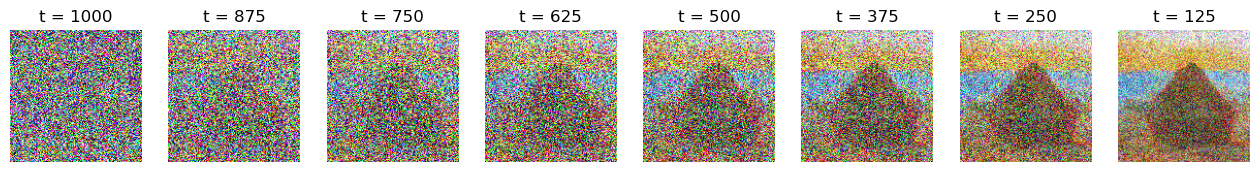

In [17]:
plt.figure(figsize=(16,5))
for i in range(8):
    plt.subplot(1,8,i+1)
    plt.imshow(postprocessImage(samples[int(i*T/8)]))
    plt.axis("off")
    plt.title("t = "+str(int(T-i*T/8)))

(64, 128, 128, 3)


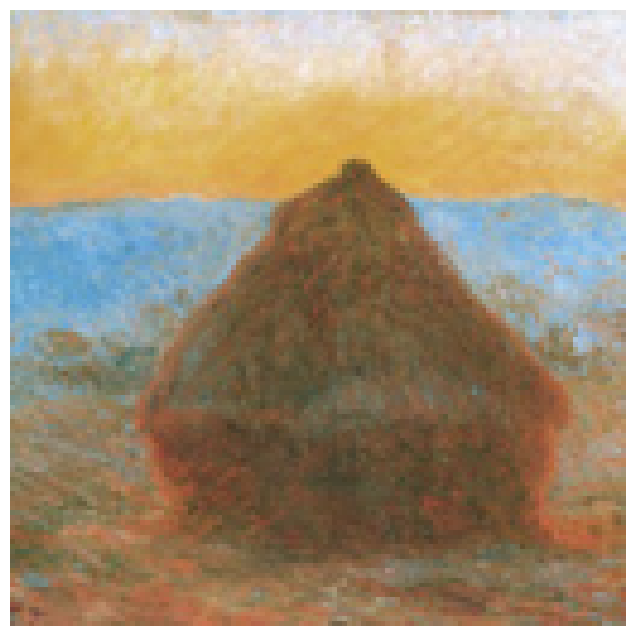

In [18]:

BATCH_SIZE=64

for test in trainLoader:
    break

print(test[3].numpy().shape)

plt.figure(figsize=(8,8))
_ = plt.imshow(np.clip(test[3].numpy()[0,:,:,:]/2+0.5, 0,1))
_ = plt.axis("off")

## Pytorch

In [19]:
%load_ext tensorboard


In [20]:
class convBlockDown(torch.nn.Module):
    def __init__(self, chIn, chOut, kernelSize=3):
        super().__init__()
        self.padding = int(np.floor(kernelSize/2))
        
        self.act = torch.nn.LeakyReLU()
        self.bn = torch.nn.BatchNorm2d(chIn)
        self.conv1 = torch.nn.Conv2d(chIn, chIn, kernelSize, padding="same")
        self.conv2 = torch.nn.Conv2d(chIn, chOut, kernelSize, stride=(2,2), padding=self.padding)
        self.conv3 = torch.nn.Conv2d(chOut, chOut, kernelSize, padding="same")
        self.conv4 = torch.nn.Conv2d(chOut, chOut, kernelSize, padding="same")
    
    def forward(self, x):
        x = self.bn(x)
        x = self.act(x)
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.conv3(x)
        x = self.act(x)
        x = self.conv4(x)
        return x
    
class convBlock(torch.nn.Module):
    def __init__(self, ch, kernelSize=3):
        super().__init__()
        self.act = torch.nn.LeakyReLU()
        self.bn = torch.nn.BatchNorm2d(ch)
        self.conv1 = torch.nn.Conv2d(ch, ch, kernelSize, padding="same")
        self.conv2 = torch.nn.Conv2d(ch, ch, kernelSize, dilation=2, padding="same")
        self.conv3 = torch.nn.Conv2d(ch, ch, kernelSize, padding="same")
        self.conv4 = torch.nn.Conv2d(ch, ch, kernelSize, padding="same")
    
    def forward(self, x):
        x = self.bn(x)
        x = self.act(x)
        x = self.conv1(x)
        x = self.act(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.conv3(x)
        x = self.act(x)
        x = self.conv4(x)
        return x
    
class convBlockUp(torch.nn.Module):
    def __init__(self, chIn, chOut, chConcat, kernelSize=3):
        super().__init__()
        self.act = torch.nn.LeakyReLU()
        self.bn = torch.nn.BatchNorm2d(chIn)
        self.conv1 = torch.nn.Conv2d(chIn, chIn, kernelSize, padding="same")
        self.upsample2 = torch.nn.UpsamplingBilinear2d(scale_factor=2)
        self.conv3 = torch.nn.Conv2d(chIn, chOut, kernelSize, padding="same")
        self.conv4 = torch.nn.Conv2d(chOut+chConcat, chOut, kernelSize, padding="same")
    
    def forward(self, x, xConcat):
        x = self.bn(x)
        x = self.act(x)
        x = self.conv1(x)
        x = self.upsample2(x)
        x = self.act(x)
        x = self.conv3(x)
        xConcat = torch.cat((x, xConcat), 1)
        x = self.act(xConcat)
        x = self.conv4(x)
        return x


class simpleUnet(torch.nn.Module):
    def __init__(self,K=1):
        super(simpleUnet, self).__init__()
        self.K = K
        self.name = "SimpleUnet_K_"+str(K)

        self.down8 = convBlockDown(3,K*8)
        self.down16 = convBlockDown(K*8,K*16)
        self.down32 = convBlockDown(K*16,K*32)
        self.down64 = convBlockDown(K*32,K*64)

        self.center = convBlock(K*64)

        self.up64 = convBlockUp(K*64,K*32, K*32)
        self.up32 = convBlockUp(K*32,K*16, K*16)
        self.up16 = convBlockUp(K*16,K*8, K*8)
        self.up8 = convBlockUp(K*8,K*4, 3)

        self.lastLayer = torch.nn.Sequential(torch.nn.Conv2d(K*4, 3, 3, padding="same"),
                                             torch.nn.LeakyReLU(),
                                             torch.nn.Conv2d(3, 3, 3, padding="same"))
    def forward(self, x, t):
        xDown8 = self.down8(x)
        xDown16 = self.down16(xDown8)
        xDown32 = self.down32(xDown16)
        xDown64 = self.down64(xDown32)

        xCenter = self.center(xDown64)

        xUp64 = self.up64(xCenter, xDown32)
        xUp32 = self.up32(xUp64, xDown16)
        xUp16 = self.up16(xUp32, xDown8)
        xUp8 = self.up8(xUp16, x)

        return self.lastLayer(xUp8)

model = simpleUnet(K=4)

from torchview import draw_graph
import torchinfo

model_graph = draw_graph(model, input_size=((BATCH_SIZE,3,IMAGE_SIZE[0],IMAGE_SIZE[1]), [BATCH_SIZE]), expand_nested=True)

model = model.to(device)
model.train()
torchinfo.summary(model, input_size=((BATCH_SIZE,3,IMAGE_SIZE[0],IMAGE_SIZE[1]), [BATCH_SIZE]))

Layer (type:depth-idx)                   Output Shape              Param #
simpleUnet                               [64, 3, 128, 128]         --
├─convBlockDown: 1-1                     [64, 32, 64, 64]          --
│    └─BatchNorm2d: 2-1                  [64, 3, 128, 128]         6
│    └─LeakyReLU: 2-2                    [64, 3, 128, 128]         --
│    └─Conv2d: 2-3                       [64, 3, 128, 128]         84
│    └─LeakyReLU: 2-4                    [64, 3, 128, 128]         --
│    └─Conv2d: 2-5                       [64, 32, 64, 64]          896
│    └─LeakyReLU: 2-6                    [64, 32, 64, 64]          --
│    └─Conv2d: 2-7                       [64, 32, 64, 64]          9,248
│    └─LeakyReLU: 2-8                    [64, 32, 64, 64]          --
│    └─Conv2d: 2-9                       [64, 32, 64, 64]          9,248
├─convBlockDown: 1-2                     [64, 64, 32, 32]          --
│    └─BatchNorm2d: 2-10                 [64, 32, 64, 64]          64
│    └─Le

In [21]:
# model_graph.visual_graph

In [22]:
# L2=0

# def downscaleBlock(xIn, chBefore, chAfter, filtersize):
#     x = tf.keras.layers.BatchNormalization()(xIn)
#     x = tf.keras.layers.LeakyReLU()(x)

#     # xRes = tf.keras.layers.AveragePooling2D((3,3), strides=2, padding="same")(x)
#     xRes = tf.keras.layers.Conv2D(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

#     x = tf.keras.layers.Conv2D(chBefore, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     # x = tf.keras.layers.AveragePooling2D((3,3), strides=2, padding="same")(x)
#     x = tf.keras.layers.Conv2D(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

#     added = tf.math.add(x, xRes)
    
#     return added


# def upscaleBlock(xIn, chBefore, chAfter, filtersize):
#     x = tf.keras.layers.BatchNormalization()(xIn)
#     x = tf.keras.layers.LeakyReLU()(x)

#     xRes = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
#     # xRes = tf.keras.layers.Conv2DTranspose(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xIn)
#     xRes = tf.keras.layers.Conv2D(chAfter, 1, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xRes)

#     x = tf.keras.layers.Conv2D(chBefore, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
    
#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation="bilinear")(x)
#     x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)
#     # x = tf.keras.layers.Conv2DTranspose(chAfter, filtersize, strides=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Conv2D(chAfter, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

#     added = tf.math.add(x, xRes)

#     return added


# def nonLocalBlock(xIn, ch, filtersize=1):
#     theta = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
#     phi = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
#     g = tf.keras.layers.Conv2D(ch, filtersize, padding="same")(xIn)
#     out = tf.keras.layers.Attention()([theta, phi, g])
#     return tf.math.add(xIn, out)

# def resBlock(xIn, ch, filtersize=3):
#     x = tf.keras.layers.BatchNormalization()(xIn)
#     x = tf.keras.layers.LeakyReLU()(x)
#     xRes = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

#     x = tf.keras.layers.BatchNormalization()(xRes)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

#     return x + xRes


# def centerBlock(xIn, stepVector, ch, filtersize):
#     x = tf.keras.layers.BatchNormalization()(xIn)
#     x = tf.keras.layers.LeakyReLU()(x)
#     xRes = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

#     x = xRes + stepVector

#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Conv2D(ch, filtersize, dilation_rate=2, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Conv2D(ch, filtersize, dilation_rate=4, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

#     x = nonLocalBlock(x, ch)

#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Conv2D(ch, filtersize, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

#     xRes = tf.keras.layers.Conv2D(ch, 1, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xRes)

#     return x + xRes

# def get_timestep_embedding(timesteps, embedding_dim):
#   half_dim = embedding_dim // 2
#   emb = np.log(10000) / (half_dim - 1)
#   emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
#   emb = tf.cast(timesteps, dtype=tf.float32) * emb[None, :]
#   emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
#   if embedding_dim % 2 == 1:  # zero pad
#     emb = tf.pad(emb, [[0, 0], [0, 1]])
#   return tf.cast(emb, tf.float32)




# def createUnet(K=2):
#     inputs = tf.keras.Input(shape=(*IMAGE_SIZE, 3))
#     #256

#     stepInput = tf.keras.Input(shape=(1,), dtype=tf.int32)
#     tEmb = get_timestep_embedding(stepInput, K*4)
#     tEmb = tf.keras.layers.Dense(K*4)(tEmb)
#     tEmb = tf.keras.activations.swish(tEmb)
#     tEmb = tf.keras.layers.Dense(K*4)(tEmb)
#     tEmb = tf.keras.activations.swish(tEmb)
#     # embeddedStep = tf.keras.layers.Embedding(T, IMAGE_SIZE[0])(stepInput)
#     # stepMap = tf.repeat(embeddedStep, IMAGE_SIZE[0], axis=0)
#     # stepMap = tf.reshape(stepMap, (-1,*IMAGE_SIZE, 1))
#     # stepMap = tf.keras.layers.Reshape((*IMAGE_SIZE, 1))(get_timestep_embedding(stepInput, IMAGE_SIZE[0]*IMAGE_SIZE[1]))

#     xDown2 = tf.keras.layers.BatchNormalization()(inputs)
#     xDown2 = tf.keras.layers.LeakyReLU()(xDown2)
#     xDown2 = tf.keras.layers.Conv2D(K*1, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown2)

#     tEmb2 = tf.keras.layers.Dense(K*1)(tEmb)
#     tEmb2 = tf.expand_dims(tEmb2,1)
#     tEmb2 = tf.expand_dims(tEmb2,1)
#     xDown2 = xDown2 + tEmb2

#     xDown2 = tf.keras.layers.BatchNormalization()(xDown2)
#     xDown2 = tf.keras.layers.LeakyReLU()(xDown2)
#     xDown2 = tf.keras.layers.Conv2D(K*1, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown2)
    
#     xDown4 = downscaleBlock(xDown2, K*1, K*2, 3)
#     #128
#     xDown4 = tf.keras.layers.BatchNormalization()(xDown4)
#     xDown4 = tf.keras.layers.LeakyReLU()(xDown4)
#     xDown4 = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown4)

#     tEmb4 = tf.keras.layers.Dense(K*2)(tEmb)
#     tEmb4 = tf.expand_dims(tEmb4,1)
#     tEmb4 = tf.expand_dims(tEmb4,1)
#     xDown4 = xDown4 + tEmb4

#     xDown4 = tf.keras.layers.BatchNormalization()(xDown4)
#     xDown4 = tf.keras.layers.LeakyReLU()(xDown4)
#     xDown4 = tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown4)

#     xDown8 = downscaleBlock(xDown4, K*2, K*4, 3)
#     #64
#     xDown8 = tf.keras.layers.BatchNormalization()(xDown8)
#     xDown8 = tf.keras.layers.LeakyReLU()(xDown8)
#     xDown8 = tf.keras.layers.Conv2D(K*4, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown8)

#     tEmb8 = tf.keras.layers.Dense(K*4)(tEmb)
#     tEmb8 = tf.expand_dims(tEmb8,1)
#     tEmb8 = tf.expand_dims(tEmb8,1)
#     xDown8 = xDown8 + tEmb8

#     xDown8 = tf.keras.layers.BatchNormalization()(xDown8)
#     xDown8 = tf.keras.layers.LeakyReLU()(xDown8)
#     xDown8 = tf.keras.layers.Conv2D(K*4, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown8)

#     xDown16 = downscaleBlock(xDown8, K*4, K*8, 3)
#     #32
#     xDown16 = tf.keras.layers.BatchNormalization()(xDown16)
#     xDown16 = tf.keras.layers.LeakyReLU()(xDown16)
#     xDown16 = tf.keras.layers.Conv2D(K*8, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown16)

#     tEmb16 = tf.keras.layers.Dense(K*8)(tEmb)
#     tEmb16 = tf.expand_dims(tEmb16,1)
#     tEmb16 = tf.expand_dims(tEmb16,1)
#     xDown16 = xDown16 + tEmb16

#     xDown16 = tf.keras.layers.BatchNormalization()(xDown16)
#     xDown16 = tf.keras.layers.LeakyReLU()(xDown16)
#     xDown16 = tf.keras.layers.Conv2D(K*8, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown16)

#     xDown32 = downscaleBlock(xDown16, K*8, K*16, 3)
#     #16x16
#     xDown32 = tf.keras.layers.BatchNormalization()(xDown32)
#     xDown32 = tf.keras.layers.LeakyReLU()(xDown32)
#     xDown32 = tf.keras.layers.Conv2D(K*16, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown32)

#     tEmb32 = tf.keras.layers.Dense(K*16)(tEmb)
#     tEmb32 = tf.expand_dims(tEmb32,1)
#     tEmb32 = tf.expand_dims(tEmb32,1)
#     xDown32 = xDown32 + tEmb32

#     xDown32 = tf.keras.layers.BatchNormalization()(xDown32)
#     xDown32 = tf.keras.layers.LeakyReLU()(xDown32)
#     xDown32 = tf.keras.layers.Conv2D(K*16, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xDown32)

#     xCenter = resBlock(xDown32, K*16)
#     xCenter = centerBlock(xCenter, tEmb32, K*16, 3)
#     xCenter = resBlock(xCenter, K*16)
#     #16x16

#     xUp16 = upscaleBlock(xCenter, K*16, K*8, 3)
#     #32x32
#     xConcat16 = tf.keras.layers.Conv2D(K*8, 1)(xDown16)
#     xConcat16 = tf.keras.layers.Concatenate()([xUp16, xConcat16])
#     xUp16 = tf.keras.layers.BatchNormalization()(xConcat16)
#     xUp16 = tf.keras.layers.LeakyReLU()(xUp16)
#     xUp16=tf.keras.layers.Conv2D(K*8, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp16)

#     xUp16 = xUp16 + tEmb16

#     xUp16 = tf.keras.layers.BatchNormalization()(xUp16)
#     xUp16 = tf.keras.layers.LeakyReLU()(xUp16)
#     xUp16=tf.keras.layers.Conv2D(K*8, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp16)

#     xUp8 = upscaleBlock(xUp16, K*8, K*4, 3)
#     #64
#     xConcat8 = tf.keras.layers.Conv2D(K*4, 1)(xDown8)
#     xConcat8 = tf.keras.layers.Concatenate()([xConcat8, xUp8])
#     xUp8 = tf.keras.layers.BatchNormalization()(xConcat8)
#     xUp8 = tf.keras.layers.LeakyReLU()(xUp8)
#     xUp8=tf.keras.layers.Conv2D(K*4, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp8)

#     xUp8 = xUp8 + tEmb8

#     xUp8 = tf.keras.layers.BatchNormalization()(xUp8)
#     xUp8 = tf.keras.layers.LeakyReLU()(xUp8)
#     xUp8=tf.keras.layers.Conv2D(K*4, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp8)

#     xUp4 = upscaleBlock(xUp8, K*4, K*2, 3)
#     #128
#     xConcat4 = tf.keras.layers.Conv2D(K*2, 1)(xDown4)
#     xConcat4 = tf.keras.layers.Concatenate()([xConcat4, xUp4])
#     xUp4 = tf.keras.layers.BatchNormalization()(xConcat4)
#     xUp4 = tf.keras.layers.LeakyReLU()(xUp4)
#     xUp4=tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp4)

#     xUp4 = xUp4 + tEmb4
    
#     xUp4 = tf.keras.layers.BatchNormalization()(xUp4)
#     xUp4 = tf.keras.layers.LeakyReLU()(xUp4)
#     xUp4=tf.keras.layers.Conv2D(K*2, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(xUp4)

#     xUp2 = upscaleBlock(xUp4, K*2, K*1, 3)
#     #256
#     xConcat2 = tf.keras.layers.Conv2D(K*2, 1)(xDown2)
#     xConcat2 = tf.keras.layers.Concatenate()([xConcat2, xUp2])
    
#     x = tf.keras.layers.BatchNormalization()(xConcat2)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Conv2D(K*1, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

#     x = x + tEmb2

#     x = tf.keras.layers.BatchNormalization()(x)
#     x = tf.keras.layers.LeakyReLU()(x)
#     x = tf.keras.layers.Conv2D(K*1, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

#     x = tf.keras.layers.Conv2D(K*1, 3, padding="same", kernel_regularizer=tf.keras.regularizers.L2(l2=L2))(x)

#     outputs = tf.keras.layers.Conv2D(3, 1, padding="same", dtype='float32')(x)

#     return tf.keras.Model(inputs=[inputs,stepInput], outputs=outputs, name="unet_T{}_K{}_DIM{}".format(T,K, IMAGE_SIZE[0]))


# # model = createUnet(K=16)

# # model.summary()

# # dot_img_file = './'+model.name +'.png'
# # tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)


In [49]:
loadExistingModel=False

if loadExistingModel:
    model = model = simpleUnet(K=4)
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

    checkpoint = torch.load(os.path.join(DATA_PATH, model.name+"epoch_1"))
    startEpoch=1
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    model = model.to(device)
    model.train()
else:
    startEpoch=0
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

In [46]:
def saveImages(model, epoch, step, summary_writer=None, maxStep=0):
    N=4
    initInput = torch.randn((N, *IMAGE_SIZE, 3), dtype=torch.float32).to(device)
    samples = [initInput]
    model.eval()

    for t in np.arange(1,T)[::-1]:
        modelInput = torch.moveaxis(samples[-1], -1, 1).to(device)
        pred = model(modelInput, torch.Tensor([t, t, t, t]))
        xt = samples[-1].detach().cpu()
        pred = torch.moveaxis(pred, 1, -1).detach().cpu()

        # sample, noise = backwardStep(xt, t, x0Pred=predX0)
        sample = backwardStep(xt, t, predNoise=pred)

        samples.append(sample)

    _ = plt.figure(figsize=(12,10))

    sampleIdx = np.linspace(1, T-1, 5)

    for j in range(N):
        for i in range(5):
            _ = plt.subplot(N, 5, j*5+i+1)
            imArr = postprocessImage(samples[int(sampleIdx[i])]).numpy()[j,:,:,:]
            plt.imshow(imArr)
            plt.axis("off")
            plt.title("Step {}".format(T-int(sampleIdx[i])))

    plt.savefig(os.path.join(DATA_PATH,"trainImagesDiffusion", 'epoch_{:04d}_step_{:04d}.png'.format(epoch, step)))

    plt.close()
    minVals=[]
    maxVals=[]
    for s in samples:
        minVals.append(np.min(s.cpu().numpy()))
        maxVals.append(np.max(s.cpu().numpy()))
    plt.plot(minVals)
    _=plt.plot(maxVals)
    plt.savefig(os.path.join(DATA_PATH,"sampleStatsDiffusion", 'epoch_{:04d}_step_{:04d}.png'.format(epoch, step)))
    plt.close()

    model.train()

In [47]:
saveImages(model, 0, 0)

In [51]:
from torch.utils.tensorboard import SummaryWriter
from torcheval import metrics

LOG_INTERVAL=5
SAVE_IMAGE_INTERVAL=1
epochs = 1001
startEpoch=0
saveModel=False
SAVE_MODEL_INTERVAL=10



log_dir = "./logs/"+model.name+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

summary_writer = SummaryWriter(log_dir)

# optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)

# Instantiate a loss function.
# lossFn = tf.keras.losses.MeanAbsoluteError()
# lossFn = tf.keras.losses.KLDivergence()
lossFn = torch.nn.MSELoss()
# lossFn = MSESSIMLoss(0.1)

mseMetric = metrics.MeanSquaredError()
mseMetric.to(device)



def trainStep(noisyImage, noise, t):
    noisyImage = torch.moveaxis(noisyImage, -1, 1)
    noise = torch.moveaxis(noise, -1, 1)
 
    noisyImage, noise, t = noisyImage.to(device), noise.to(device), t[0].to(device)
    predicted = model(noisyImage, t)

    loss = lossFn(torch.flatten(predicted, 1), torch.flatten(noise, 1))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    mseMetric.update(torch.flatten(predicted, 1), torch.flatten(noise, 1))

    return loss, predicted



maxStep=len(images)*repeats//BATCH_SIZE


for epoch in np.arange(startEpoch, startEpoch+epochs, 1):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (noisyImage, noise, t, x0) in enumerate(trainLoader):
        loss, predictedImage = trainStep(noisyImage, noise, t)

        # Log 
        if step % LOG_INTERVAL == 0:
            template = 'Epoch {}/Step {}, Loss: {:.4f}'
            print(template.format(epoch, step, mseMetric.compute()))
            
            summary_writer.add_scalar("loss", mseMetric.compute(), maxStep*epoch+step)
            summary_writer.flush()
        
    if epoch % SAVE_IMAGE_INTERVAL==0:
        print("Generate images")
        saveImages(model, epoch, step, summary_writer, maxStep)

    maxStep=step

    mseMetric.reset()

    if saveModel and epoch%SAVE_MODEL_INTERVAL==0:
    #   model.save(os.path.join(DATA_PATH, model.name+"epoch_{}".format(epoch)))
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, os.path.join(DATA_PATH, model.name+"epoch_{}".format(epoch)))

print("done")


Start of epoch 0
Epoch 0/Step 0, Loss: 0.8165
Epoch 0/Step 5, Loss: 0.8192
Epoch 0/Step 10, Loss: 0.8167
Epoch 0/Step 15, Loss: 0.8104
Epoch 0/Step 20, Loss: 0.8037
Epoch 0/Step 25, Loss: 0.8009
Epoch 0/Step 30, Loss: 0.7985
Epoch 0/Step 35, Loss: 0.7948
Epoch 0/Step 40, Loss: 0.7926
Epoch 0/Step 45, Loss: 0.7894
Epoch 0/Step 50, Loss: 0.7872
Epoch 0/Step 55, Loss: 0.7848
Epoch 0/Step 60, Loss: 0.7813
Epoch 0/Step 65, Loss: 0.7777
Epoch 0/Step 70, Loss: 0.7743
Epoch 0/Step 75, Loss: 0.7718
Epoch 0/Step 80, Loss: 0.7685
Epoch 0/Step 85, Loss: 0.7654
Epoch 0/Step 90, Loss: 0.7635
Epoch 0/Step 95, Loss: 0.7608
Epoch 0/Step 100, Loss: 0.7579
Epoch 0/Step 105, Loss: 0.7543
Epoch 0/Step 110, Loss: 0.7514
Epoch 0/Step 115, Loss: 0.7487
Epoch 0/Step 120, Loss: 0.7458
Epoch 0/Step 125, Loss: 0.7434
Epoch 0/Step 130, Loss: 0.7413
Epoch 0/Step 135, Loss: 0.7389
Epoch 0/Step 140, Loss: 0.7365
Epoch 0/Step 145, Loss: 0.7336
Generate images

Start of epoch 1
Epoch 1/Step 0, Loss: 0.6394
Epoch 1/Ste

In [ ]:
model.save(os.path.join(DATA_PATH, model.name+"_epoch_{}".format(epoch)))

## Testing

In [ ]:
initInput = torch.randn((2, *IMAGE_SIZE, 3), dtype=tf.float32)
samples = [initInput]
S=300
tauValues = np.linspace(1,T-1,S)

for t in tauValues[::-1]:
    t = int(t)
    predNoise = model((samples[-1], tf.constant([t,t])), training=False)
    xt = samples[-1]
    
    sample = backwardStepDDIM(xt, t, predNoise=predNoise)

    samples.append(sample)

_ = plt.figure(figsize=(12,5))

sampleIdx = np.linspace(0, S, 5)

for j in range(2):
    for i in range(5):
        _ = plt.subplot(2,5,j*5+i+1)
        plt.imshow(np.clip((samples[int(sampleIdx[i])].numpy()[j,:,:,:]+1)/2, 0, 1))
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i]*T/S)))

In [ ]:

variance = np.append(np.array([0]), beta[1:]*(1-alphaBar[0:T-1])/(1-alphaBar[1:T]))

def backwardStep(xt, t, predNoise):
    if t>1:
        randNoise = torch.randn(xt.shape)
    else:
        randNoise= torch.zeros_like(xt.shape)

    # compute variance

    # predX0 = (1/np.sqrt(alphaBar[t])) * xt - np.sqrt(1.0-alphaBar[t])/np.sqrt(alphaBar[t]) * predNoise 
    # predX0  = 1/np.sqrt(alpha[t]) * (xt - beta[t]/np.sqrt(1-alphaBar[t]) * predNoise )
    # xtPrev = predX0 * (np.sqrt(alphaBar[t-1])*beta[t]) / ((1-alphaBar[t])) + xt*((1-alphaBar[t-1])*np.sqrt(alpha[t]))/((1-alphaBar[t])) + sigPred[t]*randNoise

    # sigPred = np.sqrt(beta)
    # xtPrev = (1/np.sqrt(alpha[t])) * (xt - (1-alpha[t])/(np.sqrt(1-alphaBar[t])) * predNoise) + sigPred[t]*randNoise

    x0Pred = (1/np.sqrt(alphaBar[t])) * (xt - np.sqrt(1-alphaBar[t]) * predNoise)
    x0Pred = np.clip(x0Pred, -1.0, 1.0)
    meanPred = beta[t] * (np.sqrt(alphaBar[t-1]))/(1-alphaBar[t]) * x0Pred + (1-alphaBar[t-1])*(np.sqrt(alpha[t]))/(1-alphaBar[t]) * xt
    xtPrev = meanPred + np.sqrt(variance[t]) * randNoise

    return xtPrev, x0Pred



initInput = tf.random.normal((3, *IMAGE_SIZE, 3), dtype=torch.float32) * np.sqrt(1-alphaBar[T-1])
samples = [initInput]
predictedX0s = []
predNoises=[]

for t in tqdm(np.arange(1,T)[::-1]):
    # print(samples[-1])
    pred = model((samples[-1], torch.Tensor([t, t, t])), training=False)
    xt = samples[-1]
    
    # sample, noise = backwardStep(xt, t, x0Pred=predX0)
    sample, predX0 = backwardStep(xt, t, predNoise=pred)

    samples.append(sample)
    predictedX0s.append(predX0)
    predNoises.append(pred)

_ = plt.figure(figsize=(12,8))

N = 8
sampleIdx = np.linspace(1, T-1, N)

plt.figure(figsize=(8,15))
for j in range(3):
    for i in range(N):
        _ = plt.subplot(9, N, j*N+i+1)
        plt.imshow(postprocessImage(samples[int(sampleIdx[i])])[j,:,:,:])
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))
for j in np.arange(3,6):
    for i in range(N):
        _ = plt.subplot(9, N, j*N+i+1)
        plt.imshow(postprocessImage(predictedX0s[int(sampleIdx[i])-1])[j-3,:,:,:])
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))
for j in np.arange(6,9):
    for i in range(N):
        _ = plt.subplot(9, N, j*N+i+1)
        plt.imshow(postprocessImage(predNoises[int(sampleIdx[i])-1])[j-6,:,:,:])
        plt.axis("off")
        plt.title("Step {}".format(T-int(sampleIdx[i])))
plt.tight_layout()

In [ ]:
testT = 800
plt.subplot(1,2,1)
plt.imshow(postprocessImage(samples[testT])[0,:,:,:])
plt.subplot(1,2,2)
plt.imshow(postprocessImage(predNoises[testT])[0,:,:,:])
test = samples[0]

test = forwardStep(np.zeros((64,64)),500)[1]
testSamples = [forwardStep(np.zeros((16,16)),t)[1] for t in range(1000)]
print(np.min(test), np.max(test))

plt.figure()
minVals=[]
maxVals=[]
for s in predNoises:
# for s in testSamples:
    minVals.append(np.min(s))
    maxVals.append(np.max(s))
plt.plot(minVals, label="min(predNoises)")
plt.plot(maxVals, label="max(predNoises)")
minVals=[]
maxVals=[]
for s in samples:
    minVals.append(np.min(s))
    maxVals.append(np.max(s))
plt.plot(minVals, label="min(samples)")
plt.plot(maxVals, label="max(samples)")
_ = plt.legend()

In [ ]:
t=999
predX0 = 1/np.sqrt(alpha[t]) * (initInput - beta[t]/np.sqrt(1-alphaBar[t]) * predNoises[0] )
print(np.min(predX0), np.max(predX0))
print(np.min(predX0), np.max(predX0))
print(alphaBar[t])
print(1/np.sqrt(alpha[t]))
print(beta[t]/np.sqrt(1-alphaBar[t])*1/np.sqrt(alpha[t]))

In [ ]:
testIdx = np.random.randint(0,50)
testImage=tf.expand_dims(list(dataset.take(50))[int(testIdx)][0],0)
testT=tf.expand_dims(list(dataset.take(50))[int(testIdx)][2],0)
testNoise=tf.expand_dims(list(dataset.take(50))[int(testIdx)][1],0)

print(testT.numpy())
print(np.min(testImage), np.max(testImage))

In [ ]:
predNoise = model((testImage, testT))
plt.subplot(1,2,1)
plt.imshow(postprocessImage(testImage)[0,:,:,:])
plt.subplot(1,2,2)
plt.imshow(postprocessImage(predNoise)[0,:,:,:])


In [ ]:
predNoise = model((testImage, testT))
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow((predNoise.numpy()[0,:,:,:]+3)/6)
plt.title("Predicted Noise")
plt.subplot(1,3,2)
plt.title("Real Noise")
plt.imshow((testNoise.numpy()[0,:,:,:]+3)/6)
plt.subplot(1,3,3)
plt.title("Difference")
plt.imshow((testNoise.numpy()[0,:,:,:]+3)/6 - (predNoise.numpy()[0,:,:,:]+3)/6)

In [ ]:
print(np.min(testNoise.numpy()))
print(np.max(testNoise.numpy()))

In [ ]:
testTNum = testT.numpy()[0][0]